In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16818713912063300948, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9234857329
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7575328783330332804
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0


In [5]:
# print(os.listdir(""))

In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [12]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "DenseNet121"

In [13]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
# xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [14]:
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [15]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [16]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [17]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [19]:
model = DenseNet121(weights="imagenet", include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [20]:
bottleneck_final_model = model

In [21]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [22]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [23]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [24]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [25]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [26]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 7s - loss: 0.9165 - acc: 0.6895 - val_loss: 0.6623 - val_acc: 0.7845
Epoch 2/1000
 - 5s - loss: 0.6327 - acc: 0.7927 - val_loss: 0.5650 - val_acc: 0.8248
Epoch 3/1000
 - 5s - loss: 0.5638 - acc: 0.8156 - val_loss: 0.5171 - val_acc: 0.8372
Epoch 4/1000
 - 5s - loss: 0.5267 - acc: 0.8269 - val_loss: 0.4895 - val_acc: 0.8462
Epoch 5/1000
 - 5s - loss: 0.5009 - acc: 0.8351 - val_loss: 0.4717 - val_acc: 0.8513
Epoch 6/1000
 - 5s - loss: 0.4844 - acc: 0.8412 - val_loss: 0.4640 - val_acc: 0.8507
Epoch 7/1000
 - 5s - loss: 0.4697 - acc: 0.8453 - val_loss: 0.4463 - val_acc: 0.8583
Epoch 8/1000
 - 5s - loss: 0.4585 - acc: 0.8495 - val_loss: 0.4369 - val_acc: 0.8613
Epoch 9/1000
 - 5s - loss: 0.4499 - acc: 0.8525 - val_loss: 0.4272 - val_acc: 0.8625
Epoch 10/1000
 - 5s - loss: 0.4418 - acc: 0.8551 - val_loss: 0.4227 - val_acc: 0.8642
Epoch 11/1000
 - 5s - loss: 0.4355 - acc: 0.8576 - val_loss: 0.4209 - val_acc: 0.8652
Epoch 12/100

Epoch 96/1000
 - 5s - loss: 0.3255 - acc: 0.8999 - val_loss: 0.3109 - val_acc: 0.9056
Epoch 97/1000
 - 5s - loss: 0.3261 - acc: 0.8997 - val_loss: 0.3074 - val_acc: 0.9084
Epoch 98/1000
 - 5s - loss: 0.3257 - acc: 0.8999 - val_loss: 0.3081 - val_acc: 0.9077
Epoch 99/1000
 - 5s - loss: 0.3240 - acc: 0.9006 - val_loss: 0.3051 - val_acc: 0.9085
Epoch 100/1000
 - 5s - loss: 0.3242 - acc: 0.9001 - val_loss: 0.3072 - val_acc: 0.9071
Epoch 101/1000
 - 5s - loss: 0.3239 - acc: 0.9004 - val_loss: 0.3068 - val_acc: 0.9094
Epoch 102/1000
 - 5s - loss: 0.3231 - acc: 0.9009 - val_loss: 0.3051 - val_acc: 0.9086
Epoch 103/1000
 - 5s - loss: 0.3231 - acc: 0.9009 - val_loss: 0.3058 - val_acc: 0.9095
Epoch 104/1000
 - 5s - loss: 0.3223 - acc: 0.9014 - val_loss: 0.3048 - val_acc: 0.9087
Epoch 105/1000
 - 5s - loss: 0.3222 - acc: 0.9015 - val_loss: 0.3036 - val_acc: 0.9100
Epoch 106/1000
 - 5s - loss: 0.3220 - acc: 0.9016 - val_loss: 0.3052 - val_acc: 0.9089
Epoch 107/1000
 - 5s - loss: 0.3225 - acc: 0.90

Epoch 191/1000
 - 5s - loss: 0.3058 - acc: 0.9090 - val_loss: 0.2869 - val_acc: 0.9162
Epoch 192/1000
 - 5s - loss: 0.3060 - acc: 0.9087 - val_loss: 0.2858 - val_acc: 0.9183
Epoch 193/1000
 - 5s - loss: 0.3056 - acc: 0.9093 - val_loss: 0.2873 - val_acc: 0.9162
Epoch 194/1000
 - 5s - loss: 0.3052 - acc: 0.9091 - val_loss: 0.2870 - val_acc: 0.9169
Epoch 195/1000
 - 5s - loss: 0.3064 - acc: 0.9093 - val_loss: 0.2864 - val_acc: 0.9186
Epoch 196/1000
 - 5s - loss: 0.3057 - acc: 0.9091 - val_loss: 0.2863 - val_acc: 0.9180
Epoch 197/1000
 - 5s - loss: 0.3053 - acc: 0.9097 - val_loss: 0.2870 - val_acc: 0.9177
Epoch 198/1000
 - 5s - loss: 0.3058 - acc: 0.9091 - val_loss: 0.2885 - val_acc: 0.9157
Epoch 199/1000
 - 5s - loss: 0.3049 - acc: 0.9094 - val_loss: 0.2851 - val_acc: 0.9183
Epoch 200/1000
 - 5s - loss: 0.3054 - acc: 0.9090 - val_loss: 0.2851 - val_acc: 0.9196
Epoch 201/1000
 - 5s - loss: 0.3046 - acc: 0.9098 - val_loss: 0.2856 - val_acc: 0.9183
Epoch 202/1000
 - 5s - loss: 0.3043 - acc: 

 - 5s - loss: 0.2979 - acc: 0.9130 - val_loss: 0.2772 - val_acc: 0.9222
Epoch 286/1000
 - 5s - loss: 0.2978 - acc: 0.9133 - val_loss: 0.2768 - val_acc: 0.9213
Epoch 287/1000
 - 5s - loss: 0.2968 - acc: 0.9136 - val_loss: 0.2770 - val_acc: 0.9215
Epoch 288/1000
 - 5s - loss: 0.2978 - acc: 0.9132 - val_loss: 0.2756 - val_acc: 0.9225
Epoch 289/1000
 - 5s - loss: 0.2976 - acc: 0.9127 - val_loss: 0.2788 - val_acc: 0.9224
Epoch 290/1000
 - 5s - loss: 0.2979 - acc: 0.9135 - val_loss: 0.2777 - val_acc: 0.9220
Epoch 291/1000
 - 5s - loss: 0.2974 - acc: 0.9134 - val_loss: 0.2789 - val_acc: 0.9211
Epoch 292/1000
 - 5s - loss: 0.2959 - acc: 0.9139 - val_loss: 0.2770 - val_acc: 0.9220
Epoch 293/1000
 - 5s - loss: 0.2975 - acc: 0.9132 - val_loss: 0.2775 - val_acc: 0.9225
Epoch 294/1000
 - 5s - loss: 0.2976 - acc: 0.9136 - val_loss: 0.2781 - val_acc: 0.9210
Epoch 295/1000
 - 5s - loss: 0.2964 - acc: 0.9136 - val_loss: 0.2786 - val_acc: 0.9214
Epoch 296/1000
 - 5s - loss: 0.2969 - acc: 0.9136 - val_lo

Epoch 380/1000
 - 5s - loss: 0.2918 - acc: 0.9162 - val_loss: 0.2712 - val_acc: 0.9249
Epoch 381/1000
 - 5s - loss: 0.2925 - acc: 0.9160 - val_loss: 0.2699 - val_acc: 0.9256
Epoch 382/1000
 - 5s - loss: 0.2917 - acc: 0.9163 - val_loss: 0.2690 - val_acc: 0.9255
Epoch 383/1000
 - 5s - loss: 0.2933 - acc: 0.9161 - val_loss: 0.2697 - val_acc: 0.9262
Epoch 384/1000
 - 5s - loss: 0.2922 - acc: 0.9163 - val_loss: 0.2725 - val_acc: 0.9243
Epoch 385/1000
 - 5s - loss: 0.2921 - acc: 0.9167 - val_loss: 0.2717 - val_acc: 0.9256
Epoch 386/1000
 - 5s - loss: 0.2924 - acc: 0.9164 - val_loss: 0.2715 - val_acc: 0.9239
Epoch 387/1000
 - 5s - loss: 0.2909 - acc: 0.9168 - val_loss: 0.2708 - val_acc: 0.9256
Epoch 388/1000
 - 5s - loss: 0.2914 - acc: 0.9163 - val_loss: 0.2701 - val_acc: 0.9265
Epoch 389/1000
 - 5s - loss: 0.2919 - acc: 0.9159 - val_loss: 0.2708 - val_acc: 0.9257
Epoch 390/1000
 - 5s - loss: 0.2915 - acc: 0.9159 - val_loss: 0.2710 - val_acc: 0.9257
Epoch 391/1000
 - 5s - loss: 0.2915 - acc: 

 - 5s - loss: 0.2874 - acc: 0.9184 - val_loss: 0.2668 - val_acc: 0.9269
Epoch 475/1000
 - 5s - loss: 0.2881 - acc: 0.9184 - val_loss: 0.2659 - val_acc: 0.9280
Epoch 476/1000
 - 5s - loss: 0.2880 - acc: 0.9185 - val_loss: 0.2669 - val_acc: 0.9274
Epoch 477/1000
 - 5s - loss: 0.2885 - acc: 0.9183 - val_loss: 0.2662 - val_acc: 0.9277
Epoch 478/1000
 - 5s - loss: 0.2880 - acc: 0.9189 - val_loss: 0.2670 - val_acc: 0.9274
Epoch 479/1000
 - 5s - loss: 0.2888 - acc: 0.9184 - val_loss: 0.2667 - val_acc: 0.9276
Epoch 480/1000
 - 5s - loss: 0.2881 - acc: 0.9183 - val_loss: 0.2685 - val_acc: 0.9268
Epoch 481/1000
 - 5s - loss: 0.2882 - acc: 0.9182 - val_loss: 0.2684 - val_acc: 0.9266
Epoch 482/1000
 - 5s - loss: 0.2887 - acc: 0.9184 - val_loss: 0.2679 - val_acc: 0.9270
Epoch 483/1000
 - 5s - loss: 0.2886 - acc: 0.9183 - val_loss: 0.2683 - val_acc: 0.9273
Epoch 484/1000
 - 5s - loss: 0.2884 - acc: 0.9179 - val_loss: 0.2671 - val_acc: 0.9269
Epoch 485/1000
 - 5s - loss: 0.2887 - acc: 0.9177 - val_lo

Epoch 569/1000
 - 5s - loss: 0.2861 - acc: 0.9195 - val_loss: 0.2659 - val_acc: 0.9276
Epoch 570/1000
 - 5s - loss: 0.2856 - acc: 0.9195 - val_loss: 0.2637 - val_acc: 0.9287
Epoch 571/1000
 - 5s - loss: 0.2864 - acc: 0.9193 - val_loss: 0.2648 - val_acc: 0.9292
Epoch 572/1000
 - 5s - loss: 0.2856 - acc: 0.9191 - val_loss: 0.2643 - val_acc: 0.9292
Epoch 573/1000
 - 5s - loss: 0.2853 - acc: 0.9195 - val_loss: 0.2634 - val_acc: 0.9292
Epoch 574/1000
 - 5s - loss: 0.2852 - acc: 0.9196 - val_loss: 0.2649 - val_acc: 0.9293
Epoch 575/1000
 - 5s - loss: 0.2849 - acc: 0.9201 - val_loss: 0.2640 - val_acc: 0.9298
Epoch 576/1000
 - 5s - loss: 0.2856 - acc: 0.9196 - val_loss: 0.2644 - val_acc: 0.9289
Epoch 577/1000
 - 5s - loss: 0.2861 - acc: 0.9195 - val_loss: 0.2635 - val_acc: 0.9293
Epoch 578/1000
 - 5s - loss: 0.2853 - acc: 0.9200 - val_loss: 0.2646 - val_acc: 0.9273
Epoch 579/1000
 - 5s - loss: 0.2861 - acc: 0.9192 - val_loss: 0.2637 - val_acc: 0.9293
Epoch 580/1000
 - 5s - loss: 0.2856 - acc: 

 - 5s - loss: 0.2843 - acc: 0.9202 - val_loss: 0.2607 - val_acc: 0.9306
Epoch 664/1000
 - 5s - loss: 0.2843 - acc: 0.9207 - val_loss: 0.2648 - val_acc: 0.9286
Epoch 665/1000
 - 5s - loss: 0.2841 - acc: 0.9207 - val_loss: 0.2618 - val_acc: 0.9296
Epoch 666/1000
 - 5s - loss: 0.2842 - acc: 0.9205 - val_loss: 0.2611 - val_acc: 0.9303
Epoch 667/1000
 - 5s - loss: 0.2842 - acc: 0.9205 - val_loss: 0.2629 - val_acc: 0.9288
Epoch 668/1000
 - 5s - loss: 0.2844 - acc: 0.9203 - val_loss: 0.2615 - val_acc: 0.9304
Epoch 669/1000
 - 5s - loss: 0.2838 - acc: 0.9204 - val_loss: 0.2624 - val_acc: 0.9288
Epoch 670/1000
 - 5s - loss: 0.2845 - acc: 0.9206 - val_loss: 0.2599 - val_acc: 0.9311
Epoch 671/1000
 - 5s - loss: 0.2846 - acc: 0.9202 - val_loss: 0.2621 - val_acc: 0.9302
Epoch 672/1000
 - 5s - loss: 0.2837 - acc: 0.9206 - val_loss: 0.2618 - val_acc: 0.9297
Epoch 673/1000
 - 5s - loss: 0.2851 - acc: 0.9201 - val_loss: 0.2643 - val_acc: 0.9294
Epoch 674/1000
 - 5s - loss: 0.2845 - acc: 0.9207 - val_lo

Epoch 758/1000
 - 5s - loss: 0.2830 - acc: 0.9212 - val_loss: 0.2592 - val_acc: 0.9316
Epoch 759/1000
 - 5s - loss: 0.2827 - acc: 0.9212 - val_loss: 0.2599 - val_acc: 0.9311
Epoch 760/1000
 - 5s - loss: 0.2828 - acc: 0.9212 - val_loss: 0.2598 - val_acc: 0.9312
Epoch 761/1000
 - 5s - loss: 0.2834 - acc: 0.9207 - val_loss: 0.2612 - val_acc: 0.9310
Epoch 762/1000
 - 5s - loss: 0.2832 - acc: 0.9213 - val_loss: 0.2588 - val_acc: 0.9319
Epoch 763/1000
 - 5s - loss: 0.2825 - acc: 0.9212 - val_loss: 0.2599 - val_acc: 0.9308
Epoch 764/1000
 - 5s - loss: 0.2831 - acc: 0.9212 - val_loss: 0.2602 - val_acc: 0.9315
Epoch 765/1000
 - 5s - loss: 0.2826 - acc: 0.9217 - val_loss: 0.2614 - val_acc: 0.9308
Epoch 766/1000
 - 5s - loss: 0.2826 - acc: 0.9212 - val_loss: 0.2622 - val_acc: 0.9290
Epoch 767/1000
 - 5s - loss: 0.2814 - acc: 0.9219 - val_loss: 0.2605 - val_acc: 0.9294
Epoch 768/1000
 - 5s - loss: 0.2828 - acc: 0.9209 - val_loss: 0.2585 - val_acc: 0.9314
Epoch 769/1000
 - 5s - loss: 0.2824 - acc: 

 - 5s - loss: 0.2810 - acc: 0.9221 - val_loss: 0.2604 - val_acc: 0.9313
Epoch 853/1000
 - 5s - loss: 0.2823 - acc: 0.9210 - val_loss: 0.2583 - val_acc: 0.9307
Epoch 854/1000
 - 5s - loss: 0.2821 - acc: 0.9219 - val_loss: 0.2576 - val_acc: 0.9318
Epoch 855/1000
 - 5s - loss: 0.2813 - acc: 0.9218 - val_loss: 0.2601 - val_acc: 0.9311
Epoch 856/1000
 - 5s - loss: 0.2813 - acc: 0.9220 - val_loss: 0.2588 - val_acc: 0.9316
Epoch 857/1000
 - 5s - loss: 0.2815 - acc: 0.9219 - val_loss: 0.2574 - val_acc: 0.9321
Epoch 858/1000
 - 5s - loss: 0.2812 - acc: 0.9221 - val_loss: 0.2597 - val_acc: 0.9311
Epoch 859/1000
 - 5s - loss: 0.2816 - acc: 0.9220 - val_loss: 0.2593 - val_acc: 0.9310
Epoch 860/1000
 - 5s - loss: 0.2806 - acc: 0.9219 - val_loss: 0.2596 - val_acc: 0.9316
Epoch 861/1000
 - 5s - loss: 0.2819 - acc: 0.9221 - val_loss: 0.2583 - val_acc: 0.9319
Epoch 862/1000
 - 5s - loss: 0.2815 - acc: 0.9224 - val_loss: 0.2614 - val_acc: 0.9303
Epoch 863/1000
 - 5s - loss: 0.2815 - acc: 0.9225 - val_lo

Epoch 947/1000
 - 5s - loss: 0.2803 - acc: 0.9225 - val_loss: 0.2592 - val_acc: 0.9316
Epoch 948/1000
 - 5s - loss: 0.2804 - acc: 0.9224 - val_loss: 0.2583 - val_acc: 0.9319
Epoch 949/1000
 - 5s - loss: 0.2806 - acc: 0.9227 - val_loss: 0.2576 - val_acc: 0.9320
Epoch 950/1000
 - 5s - loss: 0.2814 - acc: 0.9221 - val_loss: 0.2564 - val_acc: 0.9328
Epoch 951/1000
 - 5s - loss: 0.2798 - acc: 0.9231 - val_loss: 0.2551 - val_acc: 0.9332
Epoch 952/1000
 - 5s - loss: 0.2800 - acc: 0.9232 - val_loss: 0.2568 - val_acc: 0.9322
Epoch 953/1000
 - 5s - loss: 0.2796 - acc: 0.9225 - val_loss: 0.2576 - val_acc: 0.9320
Epoch 954/1000
 - 5s - loss: 0.2808 - acc: 0.9223 - val_loss: 0.2577 - val_acc: 0.9321
Epoch 955/1000
 - 5s - loss: 0.2803 - acc: 0.9227 - val_loss: 0.2584 - val_acc: 0.9326
Epoch 956/1000
 - 5s - loss: 0.2801 - acc: 0.9229 - val_loss: 0.2568 - val_acc: 0.9328
Epoch 957/1000
 - 5s - loss: 0.2796 - acc: 0.9232 - val_loss: 0.2562 - val_acc: 0.9327
Epoch 958/1000
 - 5s - loss: 0.2810 - acc: 

In [27]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9219325379290028


Confusion Matrix
[[2789    0   10    4   62   61]
 [   5  444   13   15   30   12]
 [   4    3 2865   43   15  149]
 [   1    8   52  998   15   23]
 [  25    5   71   32 2637   59]
 [  44    2  207   35   55 2785]]


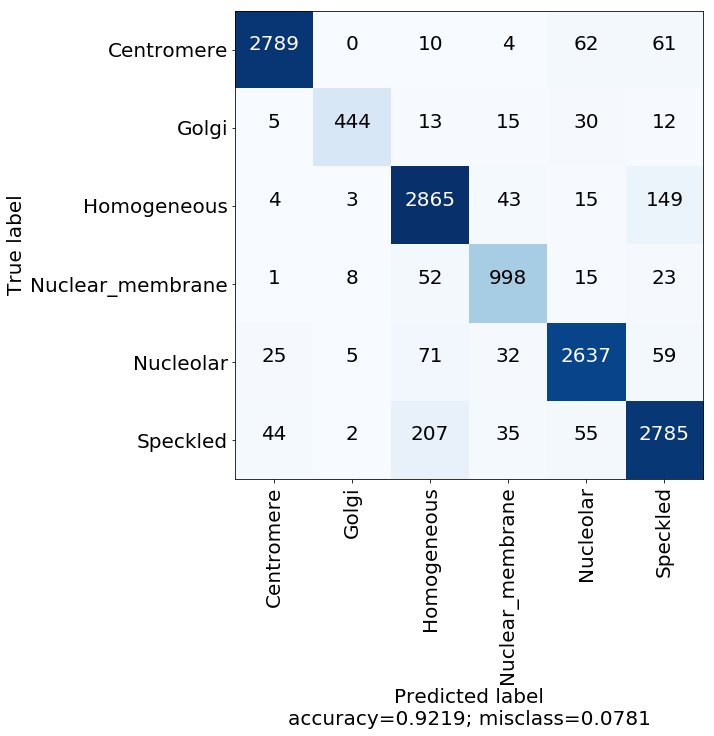

In [28]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2789    0   10    4   62   61]
 [   5  444   13   15   30   12]
 [   4    3 2865   43   15  149]
 [   1    8   52  998   15   23]
 [  25    5   71   32 2637   59]
 [  44    2  207   35   55 2785]]
                  precision    recall  f1-score   support

      Centromere       0.97      0.95      0.96      2926
           Golgi       0.96      0.86      0.91       519
     Homogeneous       0.89      0.93      0.91      3079
Nuclear_membrane       0.89      0.91      0.90      1097
       Nucleolar       0.94      0.93      0.93      2829
        Speckled       0.90      0.89      0.90      3128

     avg / total       0.92      0.92      0.92     13578



In [30]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9982104509663565
Specificity :  1.0


In [31]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 31us/step
Precision =  0.9226750275670924
Recall =  0.9219325379290028
f1_score =  0.922042496015432


In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9508448377318721


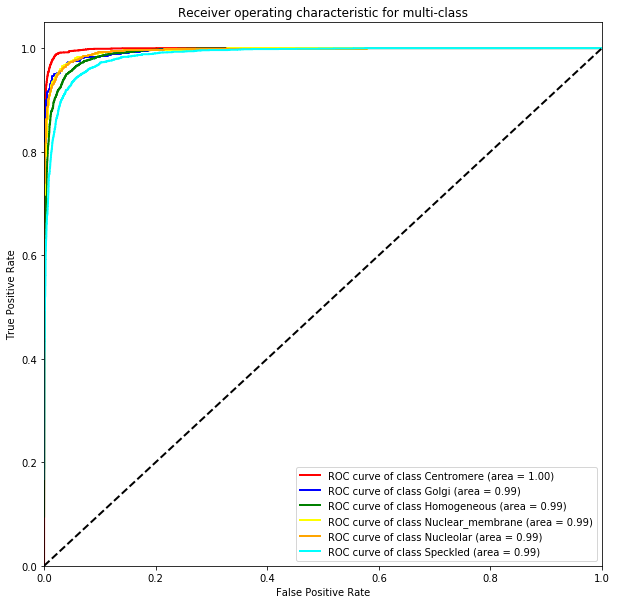

In [33]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

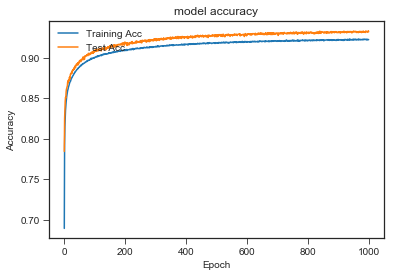

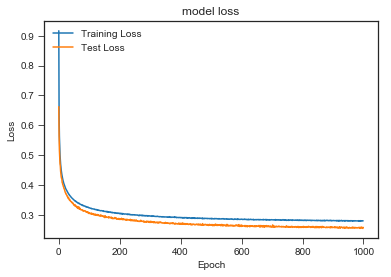

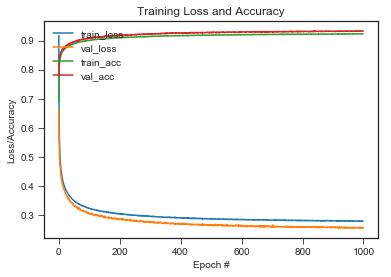

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")